In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,  Activation, Flatten

#from keras.layers import Merge



from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3# .    for pretrained CNN
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [2]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [4]:
captions = open(token, 'r').read().strip().split('\n')

## Creating a dictionary containing all the captions of the images

In [5]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [6]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
images = 'Flicker8k_Dataset/'

In [8]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [9]:
img[:5]

['Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [10]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [11]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [12]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [13]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [14]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [15]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

In [16]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [17]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

In [18]:
#Image.open(train_img[0])

We will feed these images to VGG-16 to get the encoded images. Hence we need to preprocess the images as the authors of VGG-16 did. The last layer of VGG-16 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(4096 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 4096)

In [19]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [20]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [21]:
#plt.imshow(np.squeeze(preprocess(train_img[0])))

In [22]:
model = InceptionV3(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [24]:
tryi = model_new.predict(preprocess(train_img[0]))

In [25]:
tryi.shape

(1, 2048)

In [26]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [27]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [7:47:01<00:00,  4.21it/s]       


In [28]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

In [29]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [30]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [31]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [03:55<00:00,  4.41it/s]


In [32]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [33]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [34]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [35]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [36]:
len(train_d)

6000

In [38]:
#train_d[images+'3556792157_d09d42bef7.jpg']# images = 'Flicker8k_Dataset/'

In [39]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [40]:
len(val_d)

1000

In [41]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [42]:
len(test_d)

1000

Calculating the unique words in the vocabulary.

In [43]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [44]:
words = [i.split() for i in caps]

In [45]:
unique = []
for i in words:
    unique.extend(i)

In [46]:
unique = list(set(unique))

In [47]:
# with open("unique.p", "wb") as pickle_d:
#     pickle.dump(unique, pickle_d) 

In [48]:
unique = pickle.load(open('unique.p', 'rb'))

In [49]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [50]:
word2idx = {val:index for index, val in enumerate(unique)}

In [51]:
word2idx['<start>']

7352

In [52]:
idx2word = {index:val for index, val in enumerate(unique)}

In [53]:
idx2word[5553]

'clothesline'

Calculating the maximum length among all the captions

In [54]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [55]:
len(unique), max_len

(8256, 40)

In [56]:
vocab_size = len(unique)

In [57]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [58]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [59]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [60]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [61]:
len(df)

30000

In [62]:
c = [i for i in df['captions']]
len(c)

30000

In [63]:
imgs = [i for i in df['image_id']]

In [64]:
a = c[-1]
a, imgs[-1]

('<start> Woman writing on a pad in room with gold , decorated walls . <end>',
 '997338199_7343367d7f.jpg')

In [65]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 7352
Woman => 6573
writing => 3055
on => 7732
a => 1751
pad => 8069
in => 1392
room => 479
with => 2773
gold => 5542
, => 130
decorated => 6081
walls => 4779
. => 5708
<end> => 751


In [66]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [67]:
samples_per_epoch

383454

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [68]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [69]:
embedding_size = 300

Input dimension is 4096 since we will feed it the encoded version of the image.

In [70]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [71]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])


Merging the models and creating a softmax classifier

In [72]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

NameError: name 'Merge' is not defined

In [71]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [72]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

Epoch 1/1


In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [75]:
final_model.optimizer.lr = 1e-4
#final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
 #                         verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [76]:
final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [77]:
final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [78]:
final_model.save_weights('time_inceptionV3_3.21_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [79]:
final_model.save_weights('time_inceptionV3_3.15_loss.h5')

In [ ]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)

In [81]:
#final_model.load_weights('time_inceptionV3_1.5987_loss.h5')   
final_model.load_weights('time_inceptionV3_3.15_loss.h5')

## Predict funtion

In [82]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [83]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

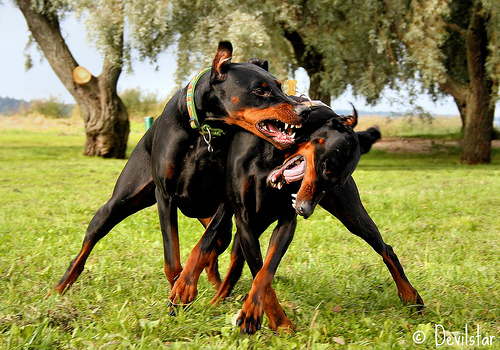

In [84]:
try_image = test_img[0]
Image.open(try_image)

In [85]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A dog is running in the grass .
Beam Search, k=3: A black and white dog with a black and white dog in the grass .
Beam Search, k=5: A black and white dog with a black and white dog .
Beam Search, k=7: A black and white dog with a black and white dog .


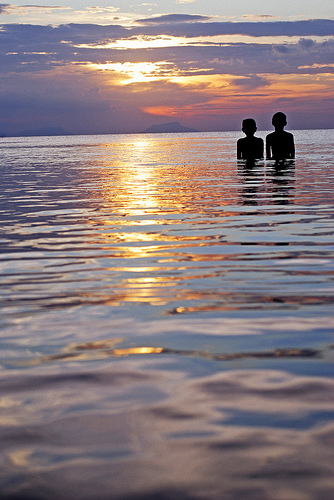

In [86]:
try_image2 = test_img[7]
Image.open(try_image2)

In [87]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A man is standing in the water .
Beam Search, k=3: A man in a black and white dog in the water .
Beam Search, k=5: A man with a black and white dog in the water .
Beam Search, k=7: A man with a man in the water .


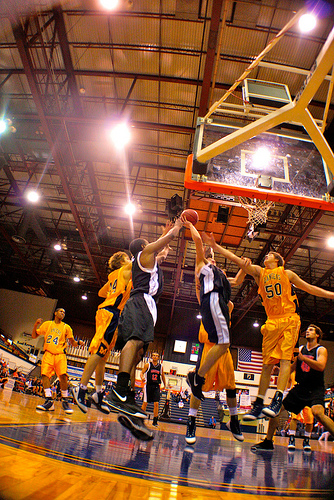

In [88]:
try_image3 = test_img[851]
Image.open(try_image3)

In [89]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A man is standing in a street .
Beam Search, k=3: A man with a white shirt is standing on a street .
Beam Search, k=5: A man with a white shirt is standing on a field .
Beam Search, k=7: A man with a white shirt is standing .


In [1]:
try_image4 = 'Flicker8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

NameError: name 'predict_captions' is not defined

In [ ]:
im = 'Flicker8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
#print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
#print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
#print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
#print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
#print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
#print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'newPhotos/a.jpeg'
#print ('Normal Max search:', predict_captions(im))
#print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
#print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
#print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
#print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
#print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
#print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = 'Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

In [ ]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)